Efficiency Example
====

The first cell is just helper functions; the second cell is where everything happens

In [9]:
import uproot
import phasespace
import numpy as np
import matplotlib.pyplot as plt
from hep_ml.reweight import GBReweighter

from typing import Tuple
from fourbody.param import helicity_param

In [10]:
def _read_branches(tree, i: int) -> np.ndarray:
    """
    Read momentum and energy branches for the i'th pion
    
    """
    # Keep only the ones where D0 bkgcat == 0
    keep = tree["D0_BKGCAT"].array() == 0
    
    rv = np.row_stack([tree[f"Pion{i}_TRUEP_{x}"] for x in ("X", "Y", "Z", "E")])
    return rv[:, keep]

def _read_mc() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Read that MC file you gave me
    
    Returns arrays: (px, py, pz, E)
    
    :returns: (4, N) shape numpy array for pi1
    :returns: (4, N) shape numpy array for pi2
    :returns: (4, N) shape numpy array for pi3
    :returns: (4, N) shape numpy array for pi4
    :returns: array of weights
    
    """
    with uproot.open("Total_DK_as_DK_MC_2017_After_PIC_Calib2_pols_merged_with_PID.root") as f:
        tree = f["DecayTree"]
        
        pi1, pi2, pi3, pi4 = (_read_branches(tree, i) for i in range(1, 5))
        
    return pi1, pi2, pi3, pi4


def _invariant_mass(p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    """
    Find invariant masses of two arrays of particles
    
    :param p1: (4xN) array of particle parameters (px, py, pz, E)
    :param p2: (4xN) array of particle parameters (px, py, pz, E)
    :returns: array of invariant masses
    
    """
    px, py, pz, e = np.add(p1, p2)
    
    return np.sqrt(e ** 2 - px ** 2 - py ** 2 - pz ** 2)


def _ks_veto(pi1: np.ndarray, pi2: np.ndarray, pi3: np.ndarray, pi4: np.ndarray) -> np.ndarray:
    """
    Which events don't pass the Ks veto
    
    :param pi1: (4xN) shape pi1 array
    :param pi2: (4xN) shape pi2 array
    :param pi3: (4xN) shape pi3 array
    :param pi4: (4xN) shape pi4 array
    :returns: boolean array of which events don't pass the Ks veto
    """
    m12 = _invariant_mass(pi1, pi2)
    m34 = _invariant_mass(pi3, pi4)
    m14 = _invariant_mass(pi1, pi4)
    m23 = _invariant_mass(pi2, pi3)
    
    min_m, max_m = 480.0, 505.0
    masks = [((m < min_m) | (m > max_m)) for m in (m12, m34, m14, m23)]
    
    return ~np.logical_and.reduce(masks)


def _generate_flat() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate flat (phsp) events according to D -> 4pi
    
    Returns arrays: (px, py, pz, E)
    
    :returns: (4, N) shape numpy array for pi1
    :returns: (4, N) shape numpy array for pi2
    :returns: (4, N) shape numpy array for pi3
    :returns: (4, N) shape numpy array for pi4
    """
    D0_MASS = 1869.62
    PION_MASS = 139.57018

    # The phasespace package returns weights
    # You could do an accept-reject here to keep only the right events but instead here I'm just going to keep the weights
    # and pass them to the reweighter
    weights, particles = phasespace.nbody_decay(D0_MASS,
                                                [PION_MASS, PION_MASS, PION_MASS, PION_MASS]
                                               ).generate(n_events=2000000)
    weights = weights.numpy()
    
    # Doesn't matter which pion is + or - since they're all identical here
    pi1, pi2, pi3, pi4 = (particles[f"p_{i}"].numpy().T for i in range(4))
    
    # Ks veto - using the same particle convention as MC
    veto_mask = _ks_veto(pi1, pi2, pi3, pi4)
    # Just set the weights for the veto'd events to 0
    print(f"{np.sum(veto_mask):,} events cut of {len(veto_mask):,}")
    weights[veto_mask] = 0
    
    return pi1, pi2, pi3, pi4, weights

In [11]:
# Read the right branches in the data file - we just care about kinematic information (momenta, energy)
mc_pi1, mc_pi2, mc_pi3, mc_pi4 = _read_mc()

# Generate "flat" (phase space distributed) events to compare the MC to
flat_pi1, flat_pi2, flat_pi3, flat_pi4, flat_weights = _generate_flat()

# Parameterise both into 5d point
# NB this function accepts (pi+ pi+ pi- pi-) (or pi- pi- pi+ pi+)
mc = helicity_param(mc_pi1, mc_pi3, mc_pi2, mc_pi4)

# You will need to add the same cuts to this flat data that you have used in the MC - not sure what these are,
# but I've done the Ks veto
flat = helicity_param(flat_pi1, flat_pi3, flat_pi2, flat_pi4)

266,088 events cut of 2,000,000


In [ ]:
# Train a reweighter
# N.B to do this "properly" (i.e. to get better results) you should initialise the GBReweighter with
# different hyperparameters; good ones to start with might be
# n_estimators=100, max_depth=6, learning_rate=0.2, min_samples_leaf=800

# N.B. also that I haven't split the dataset into train/test samples here; you'll want to do this when it comes to
# checking that the reweighter has actually worked
# You could also use the FoldingReweighter to do cross-validation
reweighter = GBReweighter()
reweighter.fit(target=flat, original=mc, target_weight=flat_weights)
efficiency_weights = reweighter.predict_weights(mc)

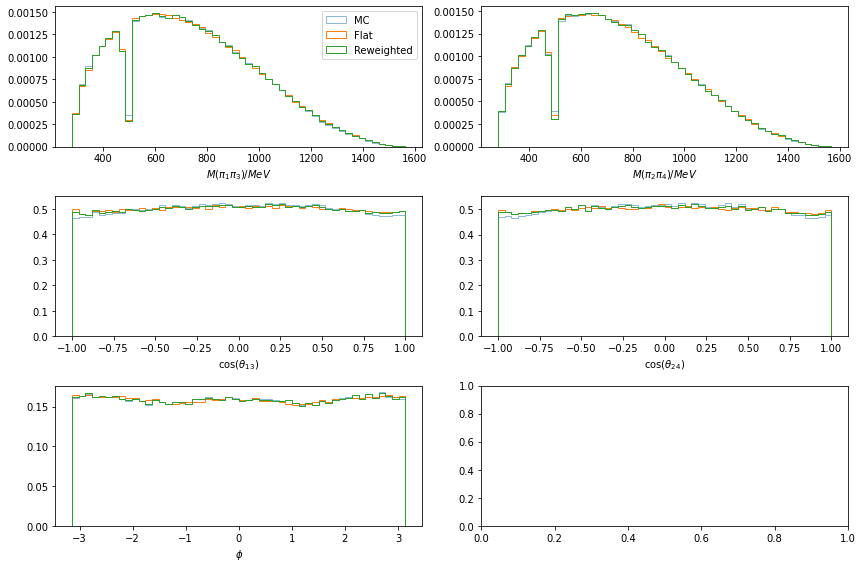

In [5]:
def _plot_stuff(mc, flat, mc_wt, flat_wt):
    fig, ax = plt.subplots(3, 2, figsize=(12, 8))
    labels = (
        r"$M(\pi_1\pi_3) /MeV$",
        r"$M(\pi_2\pi_4) /MeV$",
        r"cos($\theta_{13}$)",
        r"cos($\theta_{24}$)",
        r"$\phi$")
    kw = {"histtype": "step", "density": True}
    for a, m, f, l in zip(ax.ravel()[:-1], mc.T, flat.T, labels):
        _, bins, _ = a.hist(m, **kw, label="MC", bins=50, alpha=0.5)
        a.hist(f, **kw, label="Flat", bins=bins, weights=flat_wt)
        a.hist(m, **kw, label="Reweighted", bins=bins, weights=mc_wt)
        a.set_xlabel(l)
    
    ax.ravel()[0].legend()
    fig.tight_layout()
    plt.show()

    
_plot_stuff(mc, flat, efficiency_weights, flat_weights)

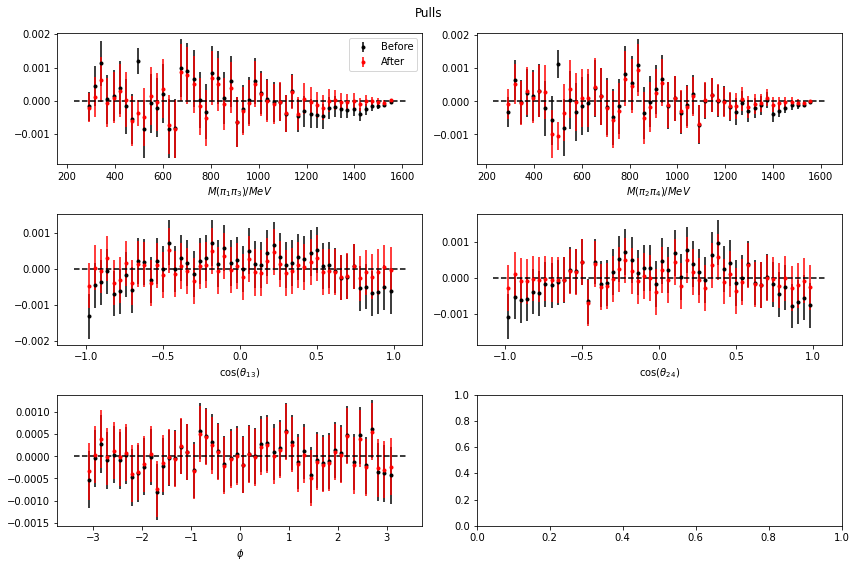

In [8]:
def _plot_pulls(mc, flat, mc_wt, flat_wt):
    fig, ax = plt.subplots(3, 2, figsize=(12, 8))
    labels = (
        r"$M(\pi_1\pi_3) /MeV$",
        r"$M(\pi_2\pi_4) /MeV$",
        r"cos($\theta_{13}$)",
        r"cos($\theta_{24}$)",
        r"$\phi$")
    kw = {"histtype": "step", "density": True}
    for a, m, f, l in zip(ax.ravel()[:-1], mc.T, flat.T, labels):
        mc_count, bins = np.histogram(m, bins=50)
        flat_count, _ = np.histogram(f, bins=bins, weights=flat_wt)
        reweighted_count, _ = np.histogram(m, bins=bins, weights=mc_wt)
        
        # Convert to float counts instead of int
        mc_count = mc_count.astype(np.float64)
        
        n_mc = np.sum(mc_count)
        n_flat = np.sum(flat_count)
        n_reweighted = np.sum(reweighted_count)
        
        mc_err = np.sqrt(mc_count) / n_mc
        # This is only approximate; really we should find the sqrt(sum(weights ** 2))
        flat_err = np.sqrt(flat_count) / n_flat
        reweighted_err = np.sqrt(reweighted_count) / n_reweighted
        
        mc_count /= n_mc
        flat_count /= n_flat
        reweighted_count /= n_reweighted
        
        before = mc_count - flat_count
        after = reweighted_count - flat_count
        
        # Poisson errors
        before_err = np.sqrt(mc_err ** 2 + flat_err ** 2)
        after_err = np.sqrt(reweighted_err ** 2 + flat_err ** 2)
        
        centres = (bins[1:] + bins[:-1]) / 2
        a.errorbar(centres, before, yerr=before_err, fmt="k.", label="Before")
        a.errorbar(centres, after, yerr=after_err, fmt="r.", label="After")
        
        a.plot(np.linspace(*a.get_xlim()), np.zeros(50), "k--")
        
        a.set_xlabel(l)
    
    fig.suptitle("Pulls")
    
    ax.ravel()[0].legend()
    fig.tight_layout()
    plt.show()
    

_plot_pulls(mc, flat, efficiency_weights, flat_weights)